<a href="https://colab.research.google.com/github/lazeicoder/Spam-and-smishing-detection-/blob/master/MulticlassXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from scipy.sparse import hstack
from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("Dataset_10191.csv")


In [3]:
label_encoder = LabelEncoder()
df["label_enc"] = label_encoder.fit_transform(df["LABEL"])

label_mapping = dict(zip(
    label_encoder.classes_,
    label_encoder.transform(label_encoder.classes_)
))

print("Label Mapping:", label_mapping)


Label Mapping: {'ham': np.int64(0), 'smishing': np.int64(1), 'spam': np.int64(2)}


In [4]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 1),
    max_features=8000,
    stop_words="english"
)

X_text = tfidf.fit_transform(df["TEXT"])


In [5]:
X_meta = (
    df[["URL", "EMAIL", "PHONE"]]
    .replace({"Yes": 1, "No": 0})
    .astype(int)
    .values
)


/tmp/ipython-input-4199362701.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1, "No": 0})


In [6]:
X = hstack([X_text, X_meta])
y = df["label_enc"]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [8]:
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)


In [9]:
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1, num_class=3, ...)

In [10]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)


In [11]:
accuracy = accuracy_score(y_test, y_pred)

macro_roc_auc = roc_auc_score(
    y_test,
    y_prob,
    multi_class="ovr",
    average="macro"
)

print("Accuracy:", accuracy)
print("Macro ROC-AUC:", macro_roc_auc)

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_,
    digits=4
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.971554683668465
Macro ROC-AUC: 0.9984080990444469

Classification Report:
              precision    recall  f1-score   support

         ham     0.9897    0.9897    0.9897       679
    smishing     0.9676    0.9647    0.9661       680
        spam     0.9575    0.9603    0.9589       680

    accuracy                         0.9716      2039
   macro avg     0.9716    0.9716    0.9716      2039
weighted avg     0.9716    0.9716    0.9716      2039


Confusion Matrix:
[[672   2   5]
 [  0 656  24]
 [  7  20 653]]


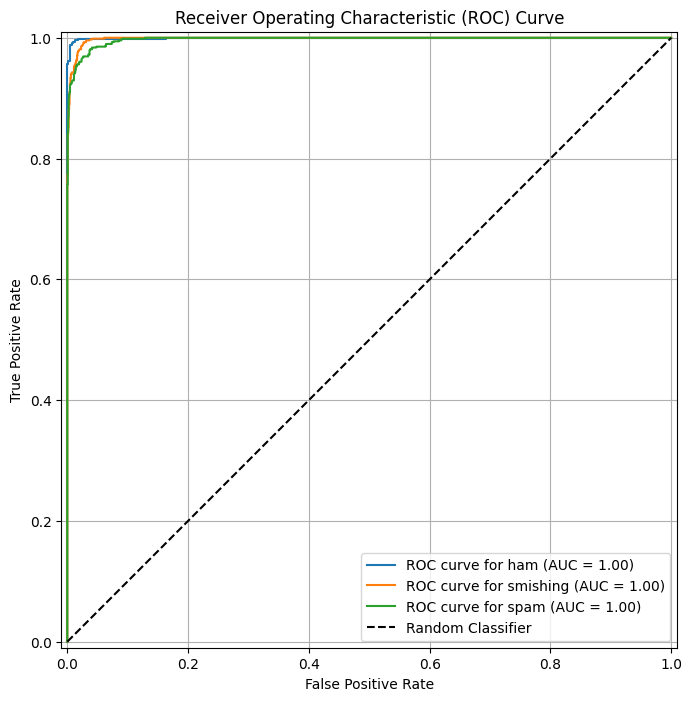

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    # Binarize y_test for the current class (one-vs-rest approach)
    y_true_binary = (y_test == i)
    RocCurveDisplay.from_predictions(
        y_true_binary,
        y_prob[:, i],
        name=f"ROC curve for {label_encoder.classes_[i]}",
        ax=plt.gca(),
        pos_label=1 # Indicate that '1' is the positive class in y_true_binary
    )
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

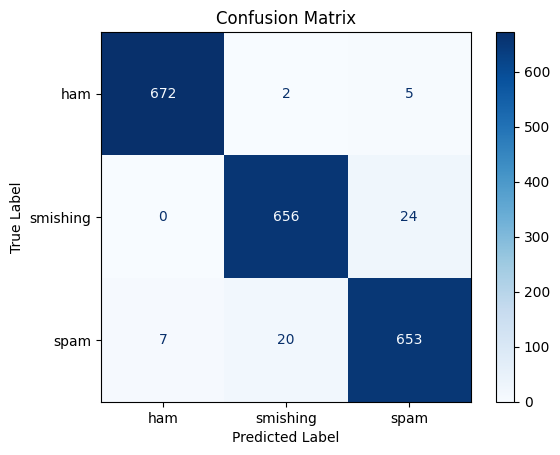

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues,
    normalize=None # Set to 'true' for normalized matrix
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()